## Data Exploration

In this notebook, we are going to take a closer look at the data. Let us begin by loading everything in.

In [3]:
import librosa
import pandas as pd
import numpy as np
from IPython.lib.display import Audio
from matplotlib import pyplot as plt
import multiprocessing
import scipy.signal
from scipy import signal

There are several files that we downloaded.

In [6]:
ls data/

anno.pkl  audio/  train_fp.csv  train_tp.csv


`anno.pkl` is a `pandas.DataFrame` containing the annotations. The `audio` folder contains the audio files.

Additionally, `train_tp.csv` and `train_fp.csv` contain bounding boxes around the vocalization on a spectrogram. The intent is that this additional data can augment training (the tp file consisting of true positives, the fp file of false positives).

In the basic, most common setup, what we want though are the labels on a per recording level, listing the species that can be heard in the recording. These live in `anno.pkl`)

In [4]:
anno = pd.read_pickle('data/anno.pkl')
anno.head()

,recording_id,species
0,4071f7aa7,[]
1,ee922d946,[]
2,939659635,[]
3,d58429096,"[coereba_flaveola, patagioenas_squamosa]"
4,0608aef17,[]


In [5]:
unique_species = np.unique(anno.species.sum())

There are 24 unique species present in the dataset.

In [6]:
unique_species.shape[0]

24

Overall, the number of times a species appears in the dataset is roughly balanced.

The least common species is `margarops_fuscatus` as it appears in only 34 recordings. The most common species is `spindalis_portoricensis`, appearing in 90 recordings.

Most of the species appear exactly 50 times.

In [8]:
from collections import Counter
Counter(anno.species.sum())

Counter({'coereba_flaveola': 50,
         'patagioenas_squamosa': 47,
         'turdus_plumbeus': 50,
         'melanerpes_portoricensis': 49,
         'leptodactylus_albilabris': 30,
         'eleutherodactylus_gryllus': 50,
         'eleutherodactylus_brittoni': 50,
         'dendroica_angelae': 50,
         'eleutherodactylus_antillensis': 43,
         'megascops_nudipes': 50,
         'eleutherodactylus_richmondi': 50,
         'todus_mexicanus': 35,
         'margarops_fuscatus': 33,
         'eleutherodactylus_coqui': 50,
         'eleutherodactylus_portoricensis': 50,
         'vireo_altiloquus': 50,
         'eleutherodactylus_unicolor': 50,
         'spindalis_portoricensis': 90,
         'eleutherodactylus_wightmanae': 50,
         'nesospingus_speculiferus': 44,
         'coccyzus_vieilloti': 41,
         'eleutherodactylus_hedricki': 50,
         'eleutherodactylus_locustus': 50,
         'loxigilla_portoricensis': 49})

There is a total of 4727 recordings across which these vocalizations occur.

In [9]:
ls data/audio/*.flac | wc -l 

4727


In [26]:
%%time

from pathlib import Path

durations, srs = [], []

for audio_file in Path('data/audio').iterdir():
    x, sr = librosa.load(audio_file, sr=None, mono=False)
    durations.append(x.shape[0] / sr)
    srs.append(sr)

CPU times: user 3min 1s, sys: 29.6 s, total: 3min 30s
Wall time: 3min 34s


In [28]:
set(durations), set(srs)

({60.0}, {48000})

All the audio files are exactly 1 minute long and were recorded wtih a 48 kHz sample rate.

In [29]:
SAMPLE_RATE = 48000

Now, please bear in mind that this is a multilabel multiclass problem. Many of the examples do not have a single species present.

In [10]:
anno.species.apply(lambda labels: labels == []).mean()

0.7605246456526338

76% of examples do not have a single species present!

Let us look for some interesting files to listen to, to get a better feel for this dataset. We start off by listening to a file containing the ambient sounds, without any of the target species present.

<audio style="display: block"
    controls
    src="data/audio/4071f7aa7.flac">
        Your browser does not support the
        <code>audio</code> element.
</audio>

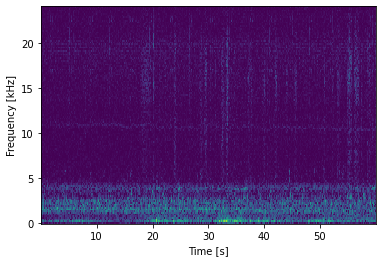

In [24]:
x, sr = librosa.load('data/audio/4071f7aa7.flac', sr=None, mono=False)

freqs, times, Sx = signal.spectrogram(x, fs=sr)
plt.pcolormesh(times, freqs / 1000, 10 * np.log10(Sx+1e-9), cmap='viridis', shading='auto')
plt.ylabel('Frequency [kHz]')
plt.xlabel('Time [s]');

As expected, the tropical soundscape is very busy! We can hear many vocalizations, but not of the species we are after.

Let's now find a couple of files where there are many species present.

In the following audio file, we can hear the following species:

In [11]:
anno.iloc[3084].species

['margarops_fuscatus', 'eleutherodactylus_coqui', 'turdus_plumbeus']

<audio style="display: block"
    controls
    src="data/audio/c12e0a62b.flac">
        Your browser does not support the
        <code>audio</code> element.
</audio>

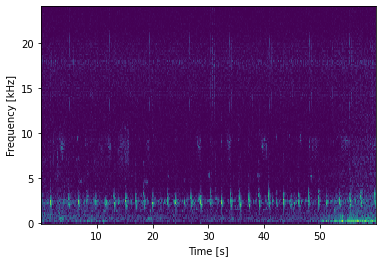

In [25]:
x, sr = librosa.load('data/audio/c12e0a62b.flac', sr=None, mono=False)

freqs, times, Sx = signal.spectrogram(x, fs=sr)
plt.pcolormesh(times, freqs / 1000, 10 * np.log10(Sx+1e-9), cmap='viridis', shading='auto')
plt.ylabel('Frequency [kHz]')
plt.xlabel('Time [s]');

Let's now listen to a recording where a single from the target species is present, the `turdus_plumbeus`. 

<audio style="display: block"
    controls
    src="data/audio/d59d099b3.flac">
        Your browser does not support the
        <code>audio</code> element.
</audio>

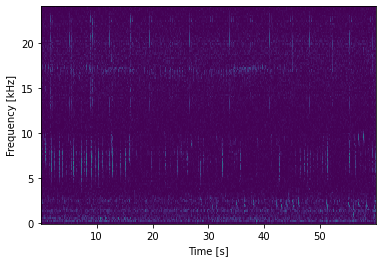

In [35]:
x, sr = librosa.load('data/audio/d59d099b3.flac', sr=None, mono=False)

freqs, times, Sx = signal.spectrogram(x, fs=sr)
plt.pcolormesh(times, freqs / 1000, 10 * np.log10(Sx+1e-9), cmap='viridis', shading='auto')
plt.ylabel('Frequency [kHz]')
plt.xlabel('Time [s]');

Before we go, let's consider the distribution of labels - how many recordings have 0 labels, 1 label, 2 labels, etc.

In [17]:
anno.species.apply(lambda labels: len(labels)).value_counts()

0    3595
1    1105
2      25
3       2
Name: species, dtype: int64

It is an infrequent occurence for any species to be present, let alone multiple species!

# CPP suitability analysis

Using the information contained in the `train_tp.csv` file, one could construct a database of calls that could be used for a CPP study. One issue with this approach though is that we would not be able to disambiguate the identity of the callers - within a species, we wouldn't know if the same or different individual is vocalizing.

Another use for this dataset would be to use it as a background for mixtures, or to use it for training a CPP model in an unsupervised / semi-supervised way.